# Classification de documents

## Imports

In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sn
from pprint import pprint
import numpy as np
import nltk
nltk.download('stopwords')

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
import pandas as pd
import re
import operator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Charger le dataset 20 newsgroups
Pour plus d'information : https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

In [2]:
news = fetch_20newsgroups(subset='all')

In [3]:
print("Number of articles: " + str(len(news.data)))

Number of articles: 18846


In [4]:
print("Number of categories: " + str(len(news.target_names)))

Number of categories: 20


In [5]:
labels = news.target_names
print(labels)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
# Exemples d'articles et de labels
for i, article in enumerate(news.data[:10]):
    print(f'===== {labels[news.target[i]]} =====')
    print(article.replace('\n', ' '), '\n')

===== rec.sport.hockey =====
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu    I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am  bit puzzled too and a bit relieved. However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final regular season game.          PENS RULE!!!   

===== comp.sys.ibm.pc.hardware =====
From: mblawson@midway.ecn.uok

## Création d'un modèle de machine learning avec Scikit-Learn
Pour plus d'information :
- Pipeline : https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- TfidfVectorizer : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- MultinomialNB : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Un article de blog qui explique le TFIDF:
- https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3

Un article de blog qui explique les naive bayes:
- https://towardsdatascience.com/naive-bayes-classifier-explained-54593abe6e18

### Séparer le dataset en features et target (X, y) et en train et test
Plus d'information : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
# Nettoyage des textes
texts = [re.sub('[^a-z]+', ' ', t.lower()).strip() for t in news.data]

In [8]:
# Mapping des targets
targets = np.array([labels[t] for t in news.target])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(texts, targets, test_size=0.2, random_state=11)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 15076
Test set size: 3770


### Entrainer un modèle de machine learning sur les données d'entrainement

In [10]:
# Définition du type de modèle
classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'), min_df=50, max_df=0.5)),
    ('classifier', MultinomialNB()),
])

In [11]:
# Entrainement du modèle
classifier.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, min_df=50,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', MultinomialNB())])

### Qu'est ce qu'il s'est passé ?

#### Le TFIDF calcule le score IDF de chaque mot du corpus


In [12]:
feature_names = classifier.named_steps['vectorizer'].get_feature_names_out()
idf_scores = classifier.named_steps['vectorizer'].idf_

In [13]:
# Taille du vocabulaire
len(feature_names)

5143

In [14]:
# Score IDF de chaque terme du vocabulaire
for i in range(0, 10):
    print(feature_names[i], ':', round(idf_scores[i], 2))

aa : 5.43
aaron : 6.07
ab : 5.07
abc : 6.43
abiding : 6.6
ability : 4.99
able : 3.63
abortion : 6.46
absence : 6.46
absolute : 5.62


In [15]:
# Les 10 mots avec le score IDF le plus haut
for word, score in sorted(zip(feature_names, idf_scores), key=operator.itemgetter(1), reverse=True)[:20]:
    print(word, round(score, 2))

accomplished 6.69
accord 6.69
acknowledge 6.69
alabama 6.69
approval 6.69
atmospheric 6.69
bach 6.69
bills 6.69
boring 6.69
brunswick 6.69
click 6.69
cloud 6.69
communicate 6.69
compatibility 6.69
confuse 6.69
connectors 6.69
copying 6.69
counted 6.69
damned 6.69
definite 6.69


#### Le TF-IDF transforme chaque document en vecteur de la taille du vocabulaire et donc le score est le TFIDF (fréquence du terme dans le document * idf)

In [16]:
tmp = classifier.named_steps['vectorizer'].transform(X_train[:10])
pd.DataFrame(tmp.toarray(), columns=classifier.named_steps['vectorizer'].get_feature_names_out())

,aa,aaron,ab,abc,abiding,ability,able,abortion,absence,absolute,...,za,zealand,zero,zeus,zip,zone,zoo,zoology,zuma,zx
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.174288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Le modèle naïf bayésien apprend la corrélation entre chaque mot et chaque catégorie

In [17]:
pd.DataFrame(classifier.named_steps['classifier'].feature_log_prob_, index=labels, columns=feature_names).T

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
aa,-9.031391,-8.958973,-8.527638,-8.319295,-8.925907,-8.017776,-8.338903,-8.847072,-8.689504,-8.534174,-9.071793,-8.714859,-8.470774,-8.614734,-8.706762,-8.461593,-8.998162,-7.815180,-8.107581,-8.958584
aaron,-8.378431,-8.849708,-9.033866,-9.196784,-8.492120,-9.190999,-8.790613,-8.659238,-9.049479,-8.145555,-9.208785,-9.318824,-8.040582,-9.211536,-9.050755,-7.785653,-7.866473,-9.143891,-8.971644,-9.090971
ab,-9.185357,-7.972288,-8.562905,-7.673833,-8.754312,-8.487363,-8.810958,-8.286023,-8.911522,-7.594498,-7.920195,-8.808036,-8.300560,-8.414757,-8.787571,-9.092512,-7.801775,-7.346560,-8.718668,-8.978612
abc,-9.131438,-8.753549,-9.194310,-9.196784,-9.181220,-9.174574,-9.074543,-9.254986,-9.259142,-9.231355,-7.017145,-9.291640,-9.122571,-9.271538,-8.933545,-9.314238,-8.652985,-9.206410,-9.068503,-9.090971
abiding,-9.185357,-9.199717,-9.194310,-9.196784,-9.181220,-9.190999,-9.169064,-8.548527,-9.259142,-9.231355,-9.267207,-8.420616,-9.217825,-9.271538,-9.267220,-9.241010,-8.115616,-9.281593,-9.067636,-8.987767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zone,-9.185357,-9.199717,-9.109107,-9.094641,-8.439665,-9.182853,-8.543065,-9.029871,-8.807916,-7.822042,-8.089170,-8.842459,-8.611304,-9.136541,-8.917161,-9.314238,-9.199511,-8.261390,-9.171456,-8.929195
zoo,-9.103881,-9.177028,-9.190190,-9.196784,-9.181220,-9.190999,-9.169064,-9.254986,-9.151984,-8.938677,-9.205760,-9.318824,-8.059584,-9.171290,-6.475637,-9.314238,-9.281239,-9.241611,-9.192008,-9.090971
zoology,-9.185357,-9.199717,-9.194310,-9.196784,-9.181220,-9.190999,-9.169064,-9.254986,-9.259142,-9.043692,-9.267207,-9.318824,-8.246820,-9.271538,-6.822597,-9.314238,-9.281239,-9.306873,-9.192008,-9.090971
zuma,-9.185357,-9.199717,-9.194310,-9.196784,-9.181220,-9.050666,-9.169064,-9.254986,-9.259142,-9.231355,-9.267207,-9.318824,-9.217825,-9.271538,-9.267220,-9.314238,-9.281239,-6.860618,-9.192008,-9.090971


#### On peut ainsi découvrir les termes les plus contributifs pour un label donné

In [18]:
pd.DataFrame(classifier.named_steps['classifier'].feature_log_prob_, index=labels, columns=feature_names).T.sort_values(by='comp.graphics', ascending=False).head(20)

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
graphics,-9.185357,-5.314237,-7.416087,-7.420574,-8.034734,-7.200497,-7.832500,-8.848613,-8.961057,-8.427580,-9.080047,-8.980262,-8.397877,-8.961555,-8.637180,-8.789679,-9.093376,-9.267382,-8.870454,-9.090971
image,-8.582574,-5.933774,-7.844051,-8.000583,-8.347116,-7.344020,-8.623092,-8.896543,-9.102963,-8.951842,-9.267207,-9.227592,-8.262846,-8.158922,-7.699968,-8.252153,-9.032665,-8.867575,-8.945224,-8.620608
file,-8.454929,-6.179292,-5.701429,-7.693263,-7.937608,-6.381948,-8.365663,-8.555797,-8.525408,-9.130741,-9.086158,-7.480125,-8.205194,-8.837050,-8.865290,-9.016348,-8.708531,-8.630774,-8.914876,-8.865745
university,-6.909220,-6.179748,-6.267078,-6.405961,-6.242822,-6.826146,-6.060213,-6.451857,-6.652640,-6.371427,-6.276828,-7.099632,-6.389357,-6.571327,-6.886828,-6.691584,-6.849493,-6.550726,-6.838807,-6.963054
thanks,-8.338730,-6.230551,-6.357800,-6.277888,-6.351325,-6.349737,-6.820068,-6.970074,-7.531938,-7.215597,-7.761640,-8.064671,-6.677436,-7.014547,-7.569346,-7.941109,-8.304052,-8.506116,-8.511403,-8.505487
files,-8.587117,-6.257314,-6.107216,-7.591001,-8.299063,-6.920978,-8.732838,-9.254986,-8.736683,-8.663302,-9.254382,-8.055814,-8.371127,-9.215454,-8.363772,-9.125657,-9.218490,-8.505991,-8.960040,-9.014971
com,-6.065623,-6.260776,-6.058572,-5.796103,-6.465125,-5.805995,-6.168205,-5.540777,-5.341518,-5.984094,-6.718282,-5.497733,-6.075079,-5.838291,-6.219172,-6.394847,-5.632970,-6.549447,-5.768002,-5.942730
bit,-7.895776,-6.265479,-7.656273,-6.714301,-6.875339,-7.303482,-7.700609,-7.857949,-7.851265,-8.340036,-8.304387,-6.766823,-7.415363,-8.014064,-7.804884,-8.013980,-8.209159,-8.241049,-8.315988,-7.874400
images,-9.134575,-6.266107,-8.184409,-8.493485,-8.993696,-8.349203,-8.851470,-9.070771,-9.259142,-9.231355,-9.267207,-9.228724,-8.867070,-9.040143,-7.389219,-9.033641,-9.281239,-9.306873,-9.192008,-8.993092
format,-9.185357,-6.275617,-7.484665,-7.545421,-8.172646,-7.678857,-8.185579,-9.254986,-9.108587,-9.106623,-8.555713,-8.744611,-8.808210,-8.991452,-8.760672,-9.178723,-9.281239,-9.242597,-8.946171,-8.990057


### Prédire les targets des données de test à l'aide du modèle entrainé

In [19]:
y_pred = classifier.predict(X_test)

Aperçu des targets prédites

In [20]:
y_pred[:20]

array(['sci.crypt', 'misc.forsale', 'rec.sport.baseball',
       'comp.windows.x', 'alt.atheism', 'sci.space', 'alt.atheism',
       'comp.os.ms-windows.misc', 'soc.religion.christian',
       'comp.os.ms-windows.misc', 'rec.sport.baseball', 'comp.graphics',
       'misc.forsale', 'sci.space', 'sci.med', 'misc.forsale',
       'misc.forsale', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware',
       'sci.crypt'], dtype='<U24')

Aperçu des targets réelles

In [21]:
y_test[:20]

array(['sci.crypt', 'comp.os.ms-windows.misc', 'sci.med',
       'comp.windows.x', 'alt.atheism', 'sci.space', 'alt.atheism',
       'comp.windows.x', 'alt.atheism', 'comp.os.ms-windows.misc',
       'rec.sport.baseball', 'misc.forsale', 'misc.forsale', 'sci.space',
       'sci.med', 'misc.forsale', 'misc.forsale',
       'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'sci.crypt'],
      dtype='<U24')

### Evaluer le modèle

#### Générer un rapport de classification
Pour plus d'information sur la précision, le recall et le f1-score : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

In [22]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.90      0.80      0.84       172
           comp.graphics       0.72      0.77      0.75       184
 comp.os.ms-windows.misc       0.81      0.79      0.80       204
comp.sys.ibm.pc.hardware       0.71      0.76      0.74       195
   comp.sys.mac.hardware       0.87      0.82      0.84       195
          comp.windows.x       0.84      0.87      0.86       204
            misc.forsale       0.77      0.79      0.78       164
               rec.autos       0.84      0.94      0.89       180
         rec.motorcycles       0.88      0.94      0.91       173
      rec.sport.baseball       0.94      0.90      0.92       217
        rec.sport.hockey       0.86      0.98      0.91       178
               sci.crypt       0.93      0.95      0.94       197
         sci.electronics       0.83      0.78      0.81       199
                 sci.med       0.92      0.92      0.92       183
         

### Générer une matrice de confusion

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

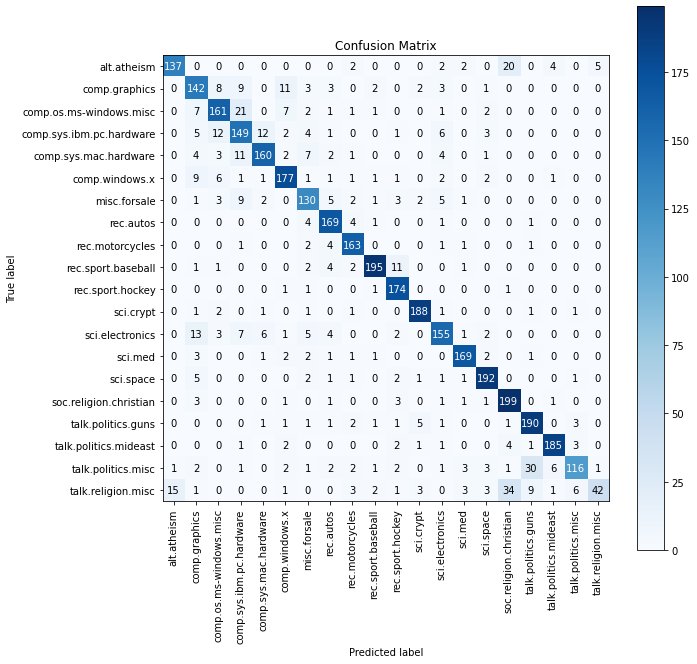

In [23]:
plot_confusion_matrix(y_test, y_pred, figsize=(10, 10), labels=labels, x_tick_rotation=90)